In [65]:
import numpy as np
from numpy import linalg
from scipy import linalg as splinalg
import matplotlib.pyplot as plt
from scipy import sparse as sp
import scipy.sparse.linalg
from functools import reduce
import itertools
from scipy import linalg
from scipy.linalg import expm, logm
from scipy.special import comb
from itertools import combinations_with_replacement, product
from collections import Counter
import copy
from scipy.linalg import ishermitian
import time

In [66]:
params = {
    'N': 10, # no. of sites
    't':1, # Hopping Amplitude
    'T': 1, # Total Time Evolution
    'tau': 0.1 # Time step
}

params['N'], params['k'] = 5, 5
params['N1'], params['N2'], params['N3'] = 2, 3, 5
params['U1'], params['U2'], params['U3'] = 0.5, 10, 0.5
params['mu'] = 0

params['start_site'], params['end_site'] = 0, 2

params['dim'], params['truncationParam_n'] = 0, 2
params['occupationTuple_lst'] = []
params['Map_ParticleLoc_OccupNo']={}
params['map_occupToD_Dim'] = {}

def dimension(params, **kwargs):
    '''
    For k identical bosonic particles on N lattice site, 
    Changes the dim and initializes the vac state
    based on dim.
    Makes change to the params - 'dim', 'vac' within the function.
    Make sure to define the parameters list as params.
    Return: Null
    '''
    N, k, dim = params['N'], params['k'], int(params['dim']) # N = number of sites, k = no. of identical bosonic particles
    params['dim'] = int(comb(N+k-1, k)) # This is for k identical bosonic particles
    params['vac'] = sp.csc_matrix(np.zeros(N))
    pass


In [67]:
def normalizeWF(psi,**kwargs):
    '''
    Return a Normalized Wavefunction
    '''
    shape, dtype = psi.shape, psi.dtype
    NWF = psi
    if np.array_equal(psi, np.zeros(shape, dtype = dtype)) == True:
        NWF = psi
    elif np.vdot(psi, psi) == 0:
        NWF = psi
    else:
        NWF = psi/(np.sqrt(np.vdot(psi, psi)))
    return NWF


In [68]:
def creationOpMatrix(params, **kwargs):
    '''
    Returns Bosonic Creation Operator
    '''
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), -1)
    return A

def annihilationOpMatrix(params, **kwargs):
    '''
    Returns Bosonic Annihilation Operator
    '''
    A = sp.diags(np.sqrt(np.arange(1, params['truncationParam_n']+1, 1)), 1)
    return A

def numOpMatrix(params, site_no, **kwargs):
    '''
    Returns Bosonic Number Operator
    '''
    createOp = creationOpMatrix(params)
    nOp = createOp@createOp.transpose()
    I = sp.identity(params['truncationParam_n']+1)
    lst = [I for _ in range(params['N'])]
    if 'tilt' in kwargs:
        lst[site_no] = nOp*site_no
        matrx = sp.csc_matrix(reduce(sp.kron, lst))
        return matrx
    else: 
        lst[site_no] = nOp
        matrix1 = sp.csc_matrix(reduce(sp.kron, lst))
        lst[site_no] = nOp@nOp
        matrix2 = sp.csc_matrix(reduce(sp.kron, lst))
        return matrix1, matrix2

def HoppingOpMatrix(params, site_no, **kwargs):
    '''
    Returns Bosonic Hopping Operator
    '''
    n, N = params['truncationParam_n'], params['N']
    matrixx = sp.csc_matrix(((n+1)**N, (n+1)**N))
    if site_no != params['N']-1:
        creationOp, annihOp = creationOpMatrix(params), annihilationOpMatrix(params)
        I = sp.identity(params['truncationParam_n']+1)
        lst = [I for _ in range(params['N'])]
        lst[site_no], lst[site_no+1] = creationOp, annihOp
        matrixx = sp.csc_matrix(reduce(sp.kron, lst))
    return matrixx

In [69]:
def Prod_OccupBasis(params, **kwargs):
    '''
    Generates all combinations using product from itertools.
    Returns: valid_combinations under the k-constraint (particle
    number conservation) and all combinations.
    '''
    n, N, k = params['truncationParam_n']+1, params['N'], params['k']
    all_combinations = dict(enumerate(itertools.product(range(n), repeat=N)))
    valid_combinations = dict(filter(lambda x: sum(x[1]) == k, all_combinations.items()))
    return valid_combinations, all_combinations
# params['truncationParam_n'], params['N'], params['k'] = 2, 2, 2

def projectionMatrix(params, **kwargs):
    '''
    Creates a projection matrix whose elements are non-zero
    for the indices of the occup_states obeying k-constraint.
    '''
    valid_combinations, all_combinations = Prod_OccupBasis(params)
    rows, cols = len(valid_combinations), len(all_combinations)
    PM = sp.csc_matrix((rows, cols))
    for i, key in enumerate(list(reversed(valid_combinations.keys()))):
        PM[i, key] = 1.0
    return PM

In [70]:
def AJJ_HamiltonianMatrix(params, **kwargs):
    '''
    Returns AJJ-BHM Hamiltonian Matrix and ground state
    '''
    n, N, k = params['truncationParam_n'], params['N'], params['k']
    H = sp.csc_matrix(((n+1)**N, (n+1)**N))
    PM = projectionMatrix(params)

    # Region1
    for i in range(params['N1']):
        HopOp, nOp_mu = HoppingOpMatrix(params, i), numOpMatrix(params, i, tilt = True)
        NumOp, NumOp_2 = numOpMatrix(params, i)
        H += -params['t']*(HopOp+HopOp.transpose()) + 0.5*params['U1']*(NumOp_2 - NumOp) - params['mu']*nOp_mu

    # Region2
    for i in range(params['N1'], params['N2']):
        HopOp, nOp_mu = HoppingOpMatrix(params, i), numOpMatrix(params, i, tilt = True)
        NumOp, NumOp_2 = numOpMatrix(params, i)
        H += -params['t']*(HopOp+HopOp.transpose()) + 0.5*params['U2']*(NumOp_2 - NumOp) - params['mu']*nOp_mu

    # Region3
    for i in range(params['N2'], params['N3']):
        HopOp, nOp_mu = HoppingOpMatrix(params, i), numOpMatrix(params, i, tilt = True)
        NumOp, NumOp_2 = numOpMatrix(params, i)
        H += -params['t']*(HopOp+HopOp.transpose()) + 0.5*params['U3']*(NumOp_2 - NumOp) - params['mu']*nOp_mu
        
    H = PM@H@PM.transpose()
    eigenval, eigenvec = sp.linalg.eigsh(H, k=1, which='SA')
    return H, eigenvec

In [71]:
def parity_op(params, **kwargs):
    '''
    Returns Parity Operator
    '''
    A = sp.diags([(-1.)**n for n in range(params['truncationParam_n']+1)])
    return A

In [72]:
parity_op(params).toarray()

array([[ 1.,  0.,  0.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  1.]])

In [73]:
def prdt_parity_op(params, **kwargs):
    '''
    Returns Parity Operator for a region in AJJ
    Args: params,

    Note:
    params['start_site']: where the region is starting
    params['end_site']: where the region is ending
    for eg, if region-1 is from 0 till 29,
    then (start_site, end_site) = (0, 30).
    '''
    A = parity_op(params)
    start_site, end_site = params['start_site'], params['end_site'] 
    createOp = creationOpMatrix(params)
    I = sp.identity(createOp.shape[0])
    lst = [I for _ in range(params['N'])]
    for i in range(start_site, end_site, 1):
        lst[i] = A
    matrixx = reduce(sp.kron, lst)
    return matrixx

In [74]:
prdt_parity_op(params).toarray().shape

(243, 243)

In [75]:
def generate_psiPrime(params, **kwargs):
    '''
    Returns wavefunction when Parity Operator for a region is applied on WFn.
    kwargs: start_site, end_site, eigenvec [Required].
    eigenvec: Ground state of AJJ.
    '''
    PM = projectionMatrix(params)
    matrixx = PM@prdt_parity_op(params)@PM.transpose()
    wfn = matrixx@kwargs['eigenvec']
    return wfn

In [76]:
H, eigenvec = AJJ_HamiltonianMatrix(params)
psi_prime = generate_psiPrime(params, eigenvec = eigenvec)

In [77]:
H.shape

(51, 51)

In [78]:
psi_prime.shape

(51, 1)

In [79]:
def time_evolutionPsiPrime(params, **kwargs):
    '''
    Returns a list of time evolved wavefunctions obtained after the application of Parity Operator of a region 
    for time 0 to T with time step 'tau'.
    This is done wrt the AJJ Hamiltonian.
    kwargs: start_site, end_site, eigenvec, H [Required].
    H: Hamiltonian of AJJ.
    eigenvec: Ground state of AJJ.
    '''
    T, tau, H, eigenvec = params['T'], params['tau'], kwargs['H'], kwargs['eigenvec']
    wfn = generate_psiPrime(params, eigenvec = eigenvec)
    time_list = np.arange(0, T, tau)
    unitary_timeOp = [expm(-1j*t*(H.toarray())) for t in time_list]
    psi_t = [uOp@eigenvec for uOp in unitary_timeOp]
    return psi_t

In [80]:
start_time = time.time()


psi_t = time_evolutionPsiPrime(params, H = H, eigenvec = eigenvec)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 0.016933202743530273 seconds


In [116]:
def N_op(params, region_number, **kwargs):
    '''
    Returns N operator = sum of n_{i} where i belongs to a region.
    Args: params,
    region_number: takes either 1 or 3 corresponding to SF regions in SF-MIP-SF AJJ config.
    '''
    PM = projectionMatrix(params)
    print(f'PM = {PM.shape}')
    createOp = creationOpMatrix(params)
    nOp = createOp@createOp.transpose()
    if region_number == 3:
        start, end = params['N2'], params['N3']
    elif region_number == 1:
        start, end = 0, params['N2']
    I = sp.identity(createOp.shape[0])
    lst = [I for _ in range(params['N'])]
    # matrixx = PM@(sp.csc_matrix((createOp.shape[0]**params['N'], createOp.shape[0]**params['N'])))@PM.transpose()
    matrixx = sp.csc_matrix((createOp.shape[0]**params['N'], createOp.shape[0]**params['N']))
    for i in range(start, end):
        lst[i] = nOp
        # matrixx += (PM@reduce(sp.kron, lst)@PM.transpose())
        matrixx += reduce(sp.kron, lst)
        lst[i] = I

    matrixx = PM@matrixx@PM.transpose()
    print(f'matrixx={matrixx.shape}')
    return matrixx 

In [117]:
start_time = time.time()


N1_op = N_op(params, region_number = 1)


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

PM = (51, 243)
matrixx=(51, 51)
Elapsed time: 0.008852481842041016 seconds


In [118]:
def N1_minusN3_exp(params, **kwargs):
    '''
    Returns the list of expectation values of N1 - N3 operators wrt the time evolved psi-prime for different final times.
    kwargs: psi_t [Optional] - if passed, function uses this else uses the one generated from functn 'time_evolutionPsiPrime'
    '''
    if 'psi_t' in kwargs:
        psi_t = kwargs['psi_t']
    elif 'psi_t' not in kwargs:
        psi_t = time_evolutionPsiPrime(params, H = H, eigenvec = eigenvec)

    print(f'psit.shape={psi_t[0].shape}')
    N1 = N_op(params, region_number = 1)
    print(f'N1.shape={N1.shape}')
    N2 = N_op(params, region_number = 3)
    print(f'N2.shape={N2.shape}')
    N_diff_exp = [np.vdot(psit, (N1-N2)@psit) for psit in psi_t]
    return N_diff_exp  

psit.shape=(51, 1)
PM = (51, 243)
matrixx=(51, 51)
N1.shape=(51, 51)
PM = (51, 243)
matrixx=(51, 51)
N2.shape=(51, 51)
N_diff_exp=[(0.6109858588909199+0j), (0.6109858588909197+0j), (0.6109858588909198+0j), (0.6109858588909197-6.938893903907228e-18j), (0.6109858588909199+0j), (0.6109858588909194+2.7755575615628914e-17j), (0.6109858588909194+0j), (0.6109858588909193+0j), (0.6109858588909194+0j), (0.6109858588909193+0j)]
Elapsed time: 0.04691720008850098 seconds


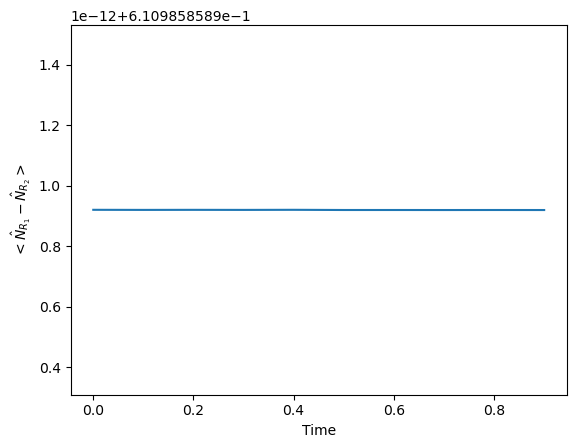

In [119]:
start_time = time.time()


N_diff_exp = N1_minusN3_exp(params)
print(f'N_diff_exp={N_diff_exp}')
t_list = np.arange(0, params['T'], params['tau']).round(1)
plt.plot(t_list, np.real(N_diff_exp))
plt.xlabel('Time')
plt.ylabel(f'$<\\hat{{N}}_{{R_1}} - \\hat{{N}}_{{R_2}}>$')


end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")